In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rating_df = pd.read_csv('/content/drive/MyDrive/수업자료/00_dataset/movielens/ml-100k/u.data', sep='\t', header=None, names = ['userID', 'movieID', 'rating', 'timestamp'])
rating_df

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
num_users = rating_df['userID'].nunique()
num_items = rating_df['movieID'].nunique()

In [4]:
rating_df['userID'] = rating_df['userID'] - 1 # userID를 index로 쓸 수 있게 0부터 설정
rating_df['movieID'] = rating_df['movieID'] - 1

In [5]:
rating_df.head(1)

,userID,movieID,rating,timestamp
0,195,241,3,881250949


In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(rating_df, test_size = 0.1, random_state = 615)

In [9]:
# user - item matrix로 변환
from scipy.sparse import csr_matrix

x_train = csr_matrix(
    (train_data['rating'], (train_data['userID'], train_data['movieID'])),
    shape = (num_users, num_items)
).toarray()/5 # 0-5점 사이의 rating이기 때문에 스케일링
# 원래는 바로 sparse matrix로 바로 구현

x_test = csr_matrix(
    (test_data['rating'], (test_data['userID'], test_data['movieID'])),
    shape = (num_users, num_items)
).toarray()/5

In [10]:
x_train

array([[1. , 0.6, 0.8, ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 1. , 0. , ..., 0. , 0. , 0. ]])

## - 추천 시스템 모델 build --> VAE 사용

In [12]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import numpy as np

In [29]:
class AutoRec(keras.Model):
    def __init__(self, latent_dim, n_items):
        super(AutoRec, self).__init__()

        self.latent_dim = latent_dim
        self.n_items = n_items

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        encoder_inputs = keras.Input(shape = (self.n_items,))
        x = layers.Dense(2048, activation = 'relu')(encoder_inputs)
        x = layers.Dense(1024, activation = 'relu')(x)
        x = layers.Dense(512, activation = 'relu')(x)

        z_mean = layers.Dense(self.latent_dim, name = 'z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name = 'z_log_var')(x)

        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name = 'encoder')

        return encoder

    def build_decoder(self):
        latent_inputs = keras.Input(shape = (self.latent_dim,))
        x = layers.Dense(512, activation = 'relu')(latent_inputs)
        x = layers.Dense(1024, activation = 'relu')(x)
        x = layers.Dense(2048, activation = 'relu')(x)

        decoder_outputs = layers.Dense(self.n_items, activation = 'sigmoid')(x)

        decoder = keras.Model(latent_inputs, decoder_outputs)
        return decoder
    
    def call(self, x):
        self.z_mean, self.z_log_var = self.encoder(x)
        z = self.sampling(self.z_mean, self.z_log_var)
        x_decoded = self.decoder(z)
        return x_decoded
    
    def sampling(self, z_mean, z_log_var):
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))

        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def vae_loss(self, x, x_decoded):
        # recon_loss = keras.lossed.MSE(x, x_decoded) # 이렇게 하면 안 본 영화(==0)까지도 그대로 학습
        recon_loss = keras.losses.MSE(x[x>0], x_decoded[x>0]) # 본 영화만 맞출 수 있게 학습
        kl_loss = -0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) \
                                           - K.exp(self.z_log_var), axis=1)
        
        return K.mean(recon_loss + kl_loss)

In [30]:
latent_dim = 200 # 기본은 grid search를 통해 최적의 latent dim 찾기
autorec = AutoRec(latent_dim, num_items)

In [31]:
# 모델 compile
autorec.compile(optimizer='adam', loss=autorec.vae_loss) # 사용자가 지정한 loss fn 사용
autorec(x_test).shape

TensorShape([943, 1682])

In [33]:
# 모델 훈련
autorec.fit(x_train, x_train,
                  validation_split = 0.1,
                  epochs=15, batch_size=64)

# 훈련된 모델을 사용하여 테스트 데이터셋에 대한 예측 수행
test_predictions = autorec.predict(x_test)

# 예측 결과 확인
test_rmse = np.sqrt(np.mean(np.power(test_predictions - x_test, 2)))
print(f"Test RMSE: {test_rmse:.4f}")

Epoch 1/15
14/14 [==============================] - 5s 338ms/step - loss: 0.0431 - val_loss: 0.0413
Epoch 2/15
14/14 [==============================] - 3s 238ms/step - loss: 0.0423 - val_loss: 0.0418
Epoch 3/15
14/14 [==============================] - 5s 337ms/step - loss: 0.0423 - val_loss: 0.0422
Epoch 4/15
14/14 [==============================] - 3s 233ms/step - loss: 0.0426 - val_loss: 0.0411
Epoch 5/15
14/14 [==============================] - 3s 236ms/step - loss: 0.0417 - val_loss: 0.0417
Epoch 6/15
14/14 [==============================] - 3s 237ms/step - loss: 0.0414 - val_loss: 0.0419
Epoch 7/15
14/14 [==============================] - 5s 358ms/step - loss: 0.0419 - val_loss: 0.0401
Epoch 8/15
14/14 [==============================] - 3s 230ms/step - loss: 0.0414 - val_loss: 0.0414
Epoch 9/15
14/14 [==============================] - 3s 232ms/step - loss: 0.0418 - val_loss: 0.0402
Epoch 10/15
14/14 [==============================] - 3s 234ms/step - loss: 0.0418 - val_loss: 0.0408

In [34]:
true_score = x_test[x_test > 0]
true_score

array([1. , 1. , 0.8, ..., 0.8, 0.8, 0.6])

In [35]:
pred_score = test_predictions[x_test > 0]
pred_score

array([0.6719388 , 0.7567945 , 0.78662515, ..., 0.695228  , 0.7143127 ,
       0.60210824], dtype=float32)

In [36]:
r = np.corrcoef(true_score, pred_score)
r

array([[1.        , 0.39831041],
       [0.39831041, 1.        ]])

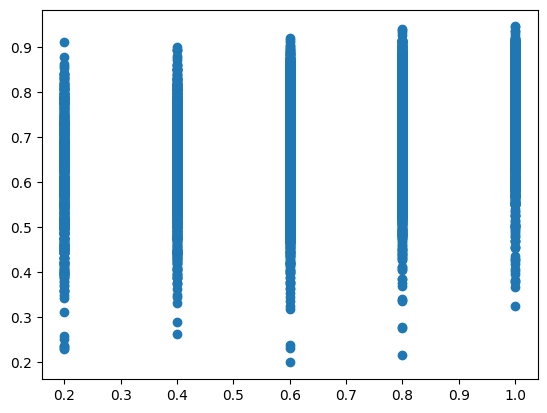

In [37]:
from matplotlib import pyplot as plt 
plt.scatter(true_score, pred_score)